In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data(%.4f) | grad(%.4f)}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    for n1, n2, in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [8]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    

    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    

    def __radd__(self, other):
        return self + other


    def __neg__(self, other):
        return self * -1


    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    

    def __rmul__(self, other):
        return self * other


    def __truediv__(self, other):
        return self * other**-1


    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supports int/flower powers"
        data = self.data**other
        out = Value(data, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward

        return out


    def exp(self):
        x = self.data
        data = math.exp(x)
        out = Value(data, (self, ), 'exp')

        def _backward():
            self.grad += data * out.grad
        out._backward = _backward

        return out


    def tanh(self):
        x = self.data
        data = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(data, (self,), 'tanh')

        def _backward():
            self.grad += (1 - data**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        order = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                order.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(order):
            node._backward()

In [10]:
# Initialisation
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

# Forward Pass
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
total = x1w1 + x2w2; sum.label='x1*w1 + x2*w2'
actv = total + b; actv.label = 'x1*w1 + x2*w2 + b'
out = actv.tanh(); out.label='out'

# Backprop
out.backward()

# Visualise
draw_dot(out)

AttributeError: 'builtin_function_or_method' object has no attribute 'label'

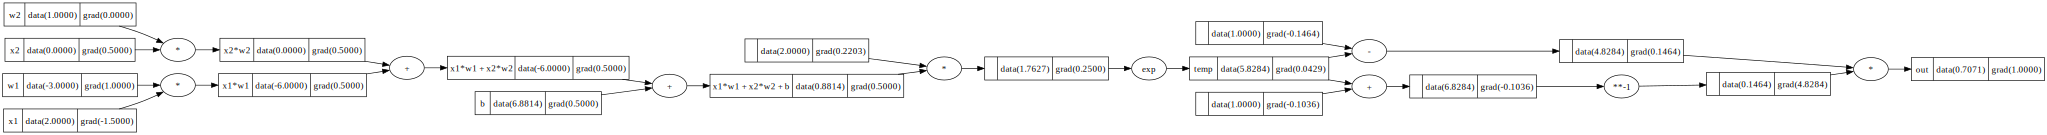

In [11]:
# Initialisation
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

# Forward Pass
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
total = x1w1 + x2w2; total.label='x1*w1 + x2*w2'
actv = total + b; actv.label = 'x1*w1 + x2*w2 + b'
temp = (2*actv).exp(); temp.label = 'temp'
out = (temp -1) / (temp + 1); out.label='out'

# Backprop
out.backward()

# Visualise
draw_dot(out)

In [58]:
class Neuron: 
    def __init__(self, in_features, actv_fn="tanh"):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(in_features)]
        self.bias = Value(random.uniform(-1,1))
        self.actv_fn = None

    def __call__(self, x):
        actv = sum(wi*xi for wi, xi in zip(self.weights, x)) + self.bias
        if self.actv_fn == "tanh":
            actv = actv.tanh()
        return actv

    def zero_grad(self):
        for w in self.weights:
            w.grad = 0.0
        self.bias.grad = 0.0

    def step(self, lr=0.1):
        for w in self.weights:
            w.data -= lr*w.grad
        self.bias.data -= lr*self.bias.grad


class Layer:
    def __init__(self, in_features, out_features):
        self.neurons = [Neuron(in_features) for _ in range(out_features)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def zero_grad(self):
        for n in self.neurons:
            n.zero_grad()

    def step(self, lr):
        for n in self.neurons:
            n.step(lr)


class MLP:
    def __init__(self, in_features, out_features, hidden_features=[]):
        self.layers = []
        for n in hidden_features:
            self.layers.append(Layer(in_features, n))
            in_features = n
        self.layers.append(Layer(in_features, out_features))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()

    def step(self, lr=0.1):
        for l in self.layers:
            l.step(lr)

In [237]:
# build dataset
Xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
Ys = [1.0, -1.0, -1.0, 1.0]

# Initialise Network
mlp = MLP(3, 1, [4,4])
losses = []

last output: [Value(data=1.076877431886653), Value(data=-0.979557656469241), Value(data=-1.0358536907685765), Value(data=0.869937211926472)]
final loss: 0.024529844925704695
best loss: 0.024529844925704695


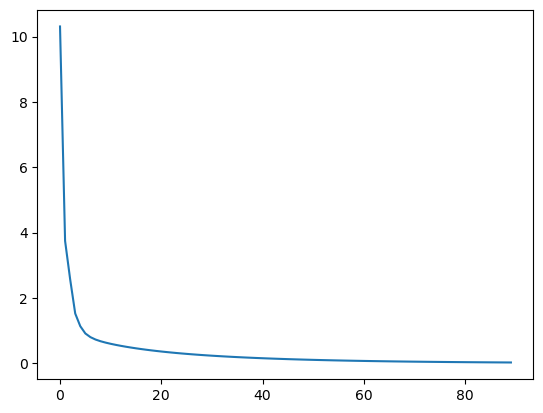

In [240]:
num_epochs = 30
lr = 0.001

for epoch in range(num_epochs):

    # forward pass
    preds = [mlp(x) for x in Xs]
    loss = sum((p-y)**2 for p, y in zip(preds, Ys))
    losses.append(loss.data)

    # backward pass
    mlp.zero_grad()
    loss.backward()
    mlp.step(lr=0.01)

print(f"last output: {preds}")
print(f"final loss: {losses[-1]}")
print(f"best loss: {min(losses)}")

plt.plot(losses)